In [1]:
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts" "torch-lr-finder" "grad-cam" "gradio" "torchinfo"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
! git clone https://github.com/niharikavadapalli/ERA-V1.git
%cd "/content/ERA-V1/ERA-V1-Session-12"

Cloning into 'ERA-V1'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463
Receiving objects: 100% (463/463), 2.48 MiB | 13.45 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/content/ERA-V1/ERA-V1-Session-12


In [3]:
import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
from torch.utils.data import DataLoader
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy
from PL_main import create_pl_model, get_max_lr, train_pl_model
from utils.visualize import plot_misclassified, plot_network_performance, plot_grad_cam, model_summary, get_target_block
from utils.datamodule import CustomCifar10DataModule

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [4]:
seed_everything(7)

class_names = {0: "airplane",
               1: "automobile",
               2: "bird",
               3: "cat",
               4: "deer",
               5: "dog",
               6: "frog",
               7: "horse",
               8: "ship",
               9: "truck"}

num_rows = 5
num_cols = 5
transparency = 0.725

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)
EPOCHS = 24
print(BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_fabric.utilities.seed:Global seed set to 7


256


In [5]:
cifar10_dm = CustomCifar10DataModule(PATH_DATASETS, BATCH_SIZE, NUM_WORKERS)

100%|██████████| 170498071/170498071 [00:02<00:00, 85247013.22it/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.61E-01


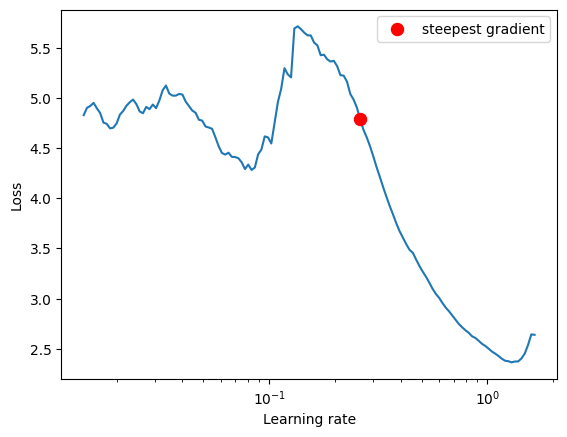

In [6]:
_,best_lr = get_max_lr(cifar10_dm,BATCH_SIZE, NUM_WORKERS, DEVICE)

In [7]:
model = create_pl_model(BATCH_SIZE, NUM_WORKERS, best_lr, epochs = EPOCHS)

In [8]:
trainer = train_pl_model(model, cifar10_dm, epochs = EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Net  | 6.6 M 
-------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9208999872207642
        test_loss           0.2532936632633209
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [9]:
model_summary(model, input_size = (3,32,32))

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitResnet                                --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Net: 1-1                               --                        [1, 3, 32, 32]            [1, 10]                   --                        --
│    └─Sequential: 2-1                   --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                  [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    │    └─BatchNorm2d: 3-2             --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    │    └─ReLU: 3-3                    --                        [1, 64, 32, 32]           [1, 

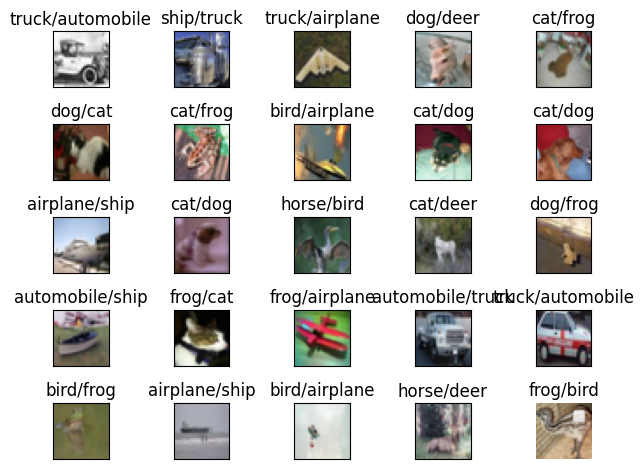

In [10]:
plot_misclassified(model,cifar10_dm.test_dataloader(), DEVICE, class_names, num_rows, num_cols)

/content/ERA-V1/ERA-V1-Session-12/utils/visualize.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(inv_image.unsqueeze(0))


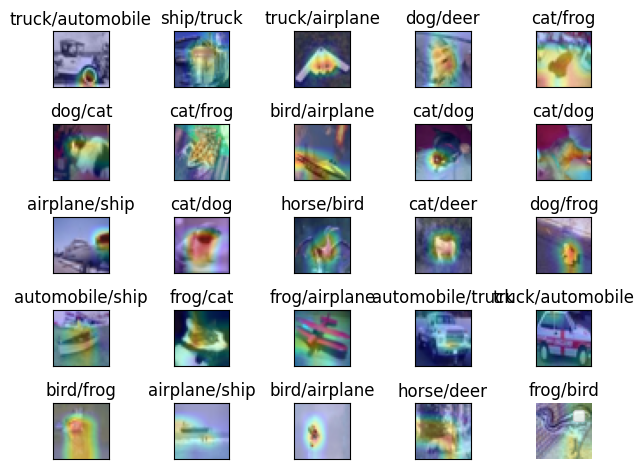

In [11]:
plot_grad_cam(model, cifar10_dm.test_dataloader(), DEVICE, class_names, rows=num_rows, columns=num_cols, transparency = transparency)

,train_loss,val_loss,val_acc
step,,,
49,NaN,NaN,NaN
49,2.313958,NaN,NaN
99,NaN,NaN,NaN
99,2.675591,NaN,NaN
149,NaN,NaN,NaN


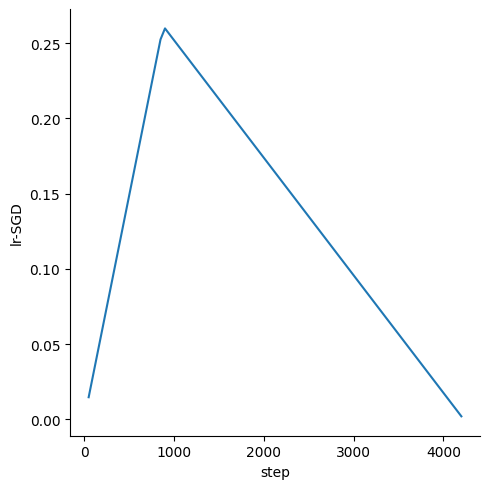

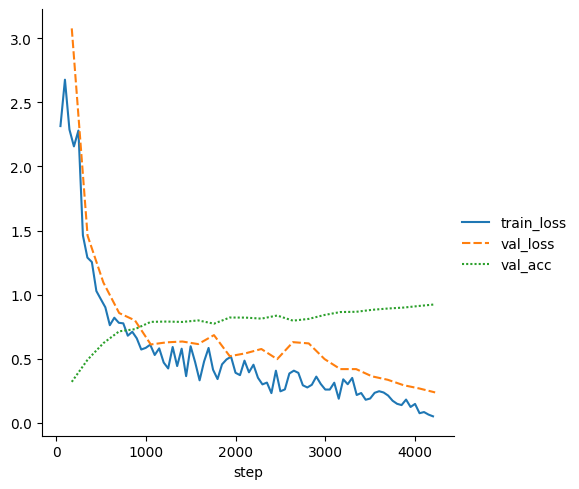

In [12]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
sn.relplot(data=metrics['lr-SGD'], kind="line")
del metrics['lr-SGD'],metrics['test_acc'],metrics['test_loss']
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [13]:
torch.save(model.state_dict(), "custom_resnet_model.pth")